# Homework 1

Yi Zuo
07/09/2020

## TOC:

* [0. Tutorial to ACCRE and Jupyter Notebook](#prep)
* [1. Introduction](#intro)
* [2. Lasso as a benchmark](#lasso)
* [3. Neural networks](#nn)
* [4. Your job](#job)
    * [4.1 Predict with lasso (15 pt)](#plasso)
    * [4.2 Improve neural networks model (40 pt)](#impnn)
    * [4.3 Reproduce the bias-variance plot (20 pt)](#plt)
    * [4.4 Predict with neural networks (25 pt)](#pnn)

## 0. Tutorial to ACCRE and Jupyter Notebook <a class="anchor" id="prep"></a>
Below are the steps needed to create a Jupyter Notebook with GPU capability on ACCRE


## Step 1: Log in to ACCRE
https://keycloak.accre.vanderbilt.edu/auth/realms/ondemand/protocol/openid-connect/auth?response_type=code&scope=openid&client_id=portal.accre.vanderbilt.edu&state=Lb7EiMAOtzORbF1OV2bYUakCbhM&redirect_uri=https%3A%2F%2Fportal.accre.vanderbilt.edu%2Foidc&nonce=mxe7t2vgDeK6JRUm0dZO9X6tb-mrNiZwFY4WMN44ym8

<img src="figures/1 accre.png" alt="log in" style="width: 500px;"/>


## Step 2: Create a new Jupyter Notebook with GPU



<img src="figures/2 cr ipynb.png" alt="Drawing" style="width: 500px;"/>



## Step 3: GPU Jupyter default options

GPU Enabled Slurm Account: `p_dsi_acc`  
Number of hours: `4`  
Number of requested GPU resources: `1`  
GPU Architecture: `Pascal`  
Working directory:   
Python version: `Python 3.6.3 / Anaconda 5.0.1`    
Use a virtual environment checkbox: `uncheck`    
Python or Conda Virtual Environment: `leave blank`  


<img src="figures/3 put.png" alt="Drawing" style="width: 500px;"/>


## Step 4: Wait to connect to Jupyter





<img src="figures/4 init.png" alt="Drawing" style="width: 500px;"/>



## Step 5: create folders to store data sets



<img src="figures/5 folder.png" alt="Drawing" style="width: 500px;"/>



You can also rename the folder.



<img src="figures/6 rename.png" alt="Drawing" style="width: 500px;"/>


If it's your first time running the notebook, you may need to install some modules before loading them. Run the following code in the terminal. (a terminal can be built from the `New` button in the previous screenshot)

`conda create -n myenv`  
`source activate myenv`    
`conda install torchvision` 

## 1. Introduction <a class="anchor" id="intro"></a>

In this homework, you are asked to understand the difference between statistical modeling and deep learning modeling, get familiarized with building simple neural networks model, understand bias-variance tradeoff, and predict the outcome using the best model selected.

First, let's set up the environment. 

In [18]:
# save me from using display function every time I have multiple outputs in one cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Activate the environment that we just built.  

In [19]:
! source activate myenv

In [31]:
# import modules
import pandas as pd
import numpy as np
from sklearn.linear_model import LassoCV, Lasso
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
from torch_utils import AverageMeter
import math
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from numpy import inf

## 2. Lasso as a benchmark <a class="anchor" id="lasso"></a>

In [ ]:
# import training data set
train_data = pd.read_csv('data/train.csv') # 1022 by 258

# get training set: n = 800
train_x = train_data.loc[train_data['index']=="training",train_data.columns[2:258] ]
train_y = train_data.loc[train_data['index']=="training",'SalePrice']

# get validation set: n = 222
validation_x = train_data.loc[train_data['index']=="validation",train_data.columns[2:258] ]
validation_y = train_data.loc[train_data['index']=="validation",'SalePrice']

# run cross-validated lasso
lassocv = LassoCV(alphas = None, cv = 10, max_iter = 100000, normalize = True)
lassocv.fit(train_x, train_y)

# run lasso at best lambda
lasso = Lasso(max_iter = 10000, normalize = True)
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(train_x, train_y)

In [ ]:
# generate predictions for the validation set
y_out = lasso.predict(validation_x)

# calculate rmse in validation set
'rmse in the validation set: '+str(round(math.sqrt(((validation_y - y_out).pow(2)).mean()),3) ) # 37120

In [ ]:
# plot prediction calibration
plt.plot(validation_y,y_out, 'o')
plt.xlabel('Targeted y', fontsize=12)
plt.ylabel('Modeled y', fontsize=12)
plt.ylim(1e5,6e5)
plt.xlim(1e5,6e5)
plt.show()

## 3. Neural network <a class="anchor" id="nn"></a>

Data preparation

In [34]:
# import data
train_data = pd.read_csv('data/train.csv') # 1022 by 259
test_data = pd.read_csv('data/prediction.csv') # 438 by 258

to_use = list(range(2,258))

# training set: n = 800
train_x = train_data.loc[train_data['index']=="training",train_data.columns[to_use] ]
train_min = train_x.min()
train_max = train_x.max()

train_x = (train_x - train_min) / (train_max - train_min) # make 0-1 transformation
train_x = train_x.fillna(0)

train_X = torch.tensor(train_x.values).float()

train_y = torch.tensor(train_data.loc[train_data['index']=="training",'SalePrice'].values).float().view(-1,1)
train_Y = train_y/1e2 # divide the original price by 100 for better prediction

# validation set
validation_x = train_data.loc[train_data['index']=="validation",train_data.columns[to_use] ]

validation_x = (validation_x - train_min) / (train_max - train_min) # use training data to make 0-1 transformation

validation_x = validation_x.fillna(0)
validation_x[validation_x==inf] = 0
validation_X = torch.tensor(validation_x.values).float()

validation_y = torch.tensor(train_data.loc[train_data['index']=="validation",'SalePrice'].values).float().view(-1,1)
validation_Y = validation_y/1e2 # divide the original price by 100 for better prediction

# prediction set
test_x = test_data.iloc[:,[x - 1 for x in to_use]]
test_x = (test_x - train_min) / (train_max - train_min)
test_x = test_x.fillna(0)
test_x[test_x==inf] = 0
test_X = torch.tensor(test_x.values).float()


Define the neural networks model

In [52]:
device = torch.device("cuda")
kwargs = {'num_workers': 1, 'pin_memory': True} 
# prepare training data loader
train_ds = TensorDataset(train_X,train_Y)
validate_ds = TensorDataset(validation_X,validation_Y)

batch_size = 8
train_dl = DataLoader(train_ds, batch_size, shuffle=True,**kwargs)

validate_dl = DataLoader(validate_ds, batch_size, shuffle=True,**kwargs)

# define model
class bmodel(nn.Module):
    def __init__(self, input_d, hidden_d, output_d):
        super().__init__()
        self.fc1 = nn.Linear(input_d,hidden_d)
        self.fc2 = nn.Linear(hidden_d,output_d)
        self.dropout1 = nn.Dropout(0.5)

    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = self.dropout1(out)
        out = self.fc2(out)
        return out

# define dimensions
input_d = len(to_use)
hidden_d = 512
output_d = 1

# set up the model
model = bmodel(input_d, hidden_d, output_d).to(device)

# define optimizer
opt = torch.optim.SGD(model.parameters(), lr=1e-5)

# define loss function
loss_fn = F.mse_loss

# define the training function
def train(train_loader,model,device,loss_fn,opt):
    model.train()

    losses = AverageMeter('Loss', math.ceil(train_X.shape[0]/batch_size),':.4f')

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        
        inputs, targets = inputs.to(device), targets.to(device)
        
        # generate predictions
        pred = model(inputs)
        loss = loss_fn(pred, targets)

        # record loss
        losses.update(loss.data.item())

        # perform gradient descent
        opt.zero_grad()
        loss.backward()
        opt.step()

    return(losses.avg)

# define the validation function
def validate(val_loader, model, device, loss_fn):
    model.eval()
    with torch.no_grad():
        losses = AverageMeter('Loss',math.ceil(validation_X.shape[0]/batch_size),':.4f')

        for batch_idx, (inputs,targets) in enumerate(val_loader):
            
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs , targets )

            losses.update(loss.data.item())

    return losses.avg

# define the main function
def fit(num_epochs, model, loss_fn, opt):

    best_loss = 1e9
    is_best = False
    out_train_loss = []
    out_validate_loss = []

    for epoch in range(1,num_epochs+1):
        train_loss = train(train_dl,model,device,loss_fn,opt)
        validation_loss = validate(validate_dl, model,device, loss_fn)

        is_best = validation_loss < best_loss
        best_loss = min(validation_loss,best_loss)

        out_train_loss.append(train_loss)
        out_validate_loss.append(validation_loss)

        if is_best:
            torch.save(model.state_dict(), 'data/best_nn.pt')

        if epoch % 50 == 0:
            print("[%d/%d] training loss: %0.3f, validation loss: %.3f"
                  % (epoch,num_epochs,train_loss,validation_loss))

    print("Best validation loss: %.03f" % (best_loss))
    return out_train_loss, out_validate_loss



AssertionError: 
The NVIDIA driver on your system is too old (found version 10010).
Please update your GPU driver by downloading and installing a new
version from the URL: http://www.nvidia.com/Download/index.aspx
Alternatively, go to: https://pytorch.org to install
a PyTorch version that has been compiled with your version
of the CUDA driver.

In [ ]:
out_train_loss, out_validate_loss = fit(500, model, loss_fn, opt)

Use CPU

In [39]:
 
# prepare training data loader
train_ds = TensorDataset(train_X,train_Y)
validate_ds = TensorDataset(validation_X,validation_Y)

batch_size = 8
train_dl = DataLoader(train_ds, batch_size, shuffle=True,**kwargs)
validate_dl = DataLoader(validate_ds, batch_size, shuffle=True,**kwargs)

# define model
class bmodel(nn.Module):
    def __init__(self, input_d, hidden_d, output_d):
        super().__init__()
        self.fc1 = nn.Linear(input_d,hidden_d)
        self.fc2 = nn.Linear(hidden_d,output_d)
        self.dropout1 = nn.Dropout(0.5)

    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = self.dropout1(out)
        out = self.fc2(out)
        return out

# define dimensions
input_d = len(to_use)
hidden_d = 512
output_d = 1

# set up the model
model = bmodel(input_d, hidden_d, output_d)

# define optimizer
opt = torch.optim.SGD(model.parameters(), lr=1e-5)

# define loss function
loss_fn = F.mse_loss

# define the training function
def train(train_loader,model,loss_fn,opt):
    model.train()

    losses = AverageMeter('Loss', math.ceil(train_X.shape[0]/batch_size),':.4f')

    for batch_idx, (inputs, targets) in enumerate(train_loader):

        # generate predictions
        pred = model(inputs)
        loss = loss_fn(pred, targets)

        # record loss
        losses.update(loss.data.item())

        # perform gradient descent
        opt.zero_grad()
        loss.backward()
        opt.step()

    return(losses.avg)

# define the validation function
def validate(val_loader, model, loss_fn):
    model.eval()
    with torch.no_grad():
        losses = AverageMeter('Loss',math.ceil(validation_X.shape[0]/batch_size),':.4f')

        for batch_idx, (inputs,targets) in enumerate(val_loader):
            outputs = model(inputs)
            loss = loss_fn(outputs , targets )

            losses.update(loss.data.item())

    return losses.avg

# define the main function
def fit(num_epochs, model, loss_fn, opt):

    best_loss = 1e9
    is_best = False
    out_train_loss = []
    out_validate_loss = []

    for epoch in range(1,num_epochs+1):
        train_loss = train(train_dl,model,loss_fn,opt)
        validation_loss = validate(validate_dl, model, loss_fn)

        is_best = validation_loss < best_loss
        best_loss = min(validation_loss,best_loss)

        out_train_loss.append(train_loss)
        out_validate_loss.append(validation_loss)

        if is_best:
            torch.save(model.state_dict(), 'data/best_nn.pt')

        if epoch % 50 == 0:
            print("[%d/%d] training loss: %0.3f, validation loss: %.3f"
                  % (epoch,num_epochs,train_loss,validation_loss))

    print("Best validation loss: %.03f" % (best_loss))
    return out_train_loss, out_validate_loss



Run the process for 500 epochs and produce the training and validation loss plot with reference line from cross validated lasso. Can you derive the reference number from lasso?

In [40]:
out_train_loss, out_validate_loss = fit(500, model, loss_fn, opt)

[50/500] training loss: 64949.499, validation loss: 113349.327
[100/500] training loss: 47291.462, validation loss: 105915.008
[150/500] training loss: 41336.051, validation loss: 105893.659
[200/500] training loss: 35141.855, validation loss: 108205.847
[250/500] training loss: 36777.453, validation loss: 116755.405
[300/500] training loss: 26223.610, validation loss: 109822.608
[350/500] training loss: 28232.058, validation loss: 117337.811
[400/500] training loss: 27106.881, validation loss: 100041.031
[450/500] training loss: 25953.112, validation loss: 97249.067
[500/500] training loss: 23536.518, validation loss: 100134.246
Best validation loss: 88860.594


Text(0.5,0,'Epoch')

Text(0,0.5,'Loss')

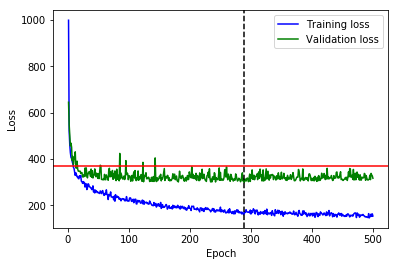

In [42]:
# plot the training and validation loss: rmse
plot_data = {'Epoch': list(range(1,501)),
             'TrainLoss': [math.sqrt(x) for x in out_train_loss],
             'ValidateLoss': [math.sqrt(x) for x in out_validate_loss] }

plot_data = pd.DataFrame(plot_data)

# find the best epoch
index_min = plot_data['ValidateLoss'].idxmin()

# plot
plt.plot('Epoch','TrainLoss',data=plot_data,color="blue",label='Training loss')
plt.plot('Epoch','ValidateLoss',data=plot_data,color="green",label='Validation loss')
plt.axhline(y=371, color='red', linestyle='-')
plt.axvline(x=index_min+1, color='k', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Plot the prediction calibration

<All keys matched successfully>

bmodel(
  (fc1): Linear(in_features=256, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
)

29930.323352747128

Text(0.5,0,'Targeted y')

Text(0,0.5,'Modeled y')

(100000.0, 800000.0)

(100000.0, 800000.0)

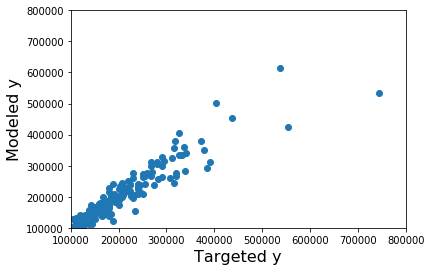

In [43]:
# prediction in the validation set
model.load_state_dict(torch.load('data/best_nn.pt'))
model.eval()
with torch.no_grad():
    preds = model(validation_X) * 1e2

# rmse
math.sqrt(mean_squared_error(validation_y, preds)) # 29691

# calibration plot of the validation set
plt.plot( (validation_y).detach().numpy(), preds.detach().numpy(), 'o')
plt.xlabel('Targeted y', fontsize=16)
plt.ylabel('Modeled y', fontsize=16)
plt.ylim(1e5,8e5)
plt.xlim(1e5,8e5)
plt.show()


Make prediction in the test set

In [44]:
# predict in the prediction set
model.eval()
with torch.no_grad():
    output = model(test_X)*1e2

# output the prediction
out = {'Id': test_data.iloc[:,0],
       'SalePrice': output.squeeze().tolist()}

out_d = pd.DataFrame(out)

out_d.to_csv("data/sample_nn_test.csv",index=False)


bmodel(
  (fc1): Linear(in_features=256, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
)

## 4. Your job <a class="anchor" id="job"></a>

Your homework will be graded by the following four parts.

### 4.1 Predict with lasso (15 pt) <a class="anchor" id="plasso"></a>

Fit a lasso model on the training set (1022 observations), and predict SalePrice on the prediction set (438 observations) 

Output the prediction in a csv file and see Google Doc for more formatting details

### 4.2 Improve neural networks model (40 pt) <a class="anchor" id="impnn"></a>

Improve the neural networks model in whatever way you want

### 4.3 Reproduce the bias-variance plot (20 pt) <a class="anchor" id="plt"></a>

Reproduce the figure, ideally have the expected pattern

### 4.4 Predict with neural networks (25 pt) <a class="anchor" id="pnn"></a>

Use your NN model to predict in the prediction set (438 observations), and see Google Doc for more formatting details

We can close the environment now.

In [11]:
! source deactivate